In [1]:
pip install pydicom

     |████████████████████████████████| 1.9 MB 11.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install plotly

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::anaconda==2020.02=py37_0
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done
Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::anaconda==2020.02=py37_0
done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - plotly


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _anaconda_depends-2020.02  |           py37_0           6 KB
    anaconda-custom            |           py37_1           3 KB
    ca-certificates-2020.10.14 |                0         121 KB
    certifi-2020.6.20          |     pyhd3eb1b0_3         155 KB
    

In [3]:
conda install scikit-image

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
from os import listdir

basepath = '../osic-pulmonary-fibrosis-progression/'
listdir(basepath)

['.DS_Store',
 'test',
 'test.csv',
 'train',
 'train.csv',
 'sample_submission.csv']

In [5]:
train = pd.read_csv(basepath + 'train.csv')
test = pd.read_csv(basepath + 'test.csv')

In [9]:
print("Total Recordings in Train Data: {:,}".format(train.shape[0]))
print("Total Recordings in Test Data: {:,}".format(test.shape[0]))

Total Recordings in Train Data: 1,549
Total Recordings in Test Data: 5


In [11]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


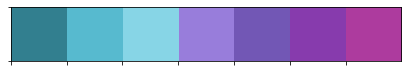

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
custom_colors = ['#327f8f','#57bacf','#87d5e6','#987ddb','#7257b5','#873bad', '#ad3b9e']
sns.palplot(sns.color_palette(custom_colors))

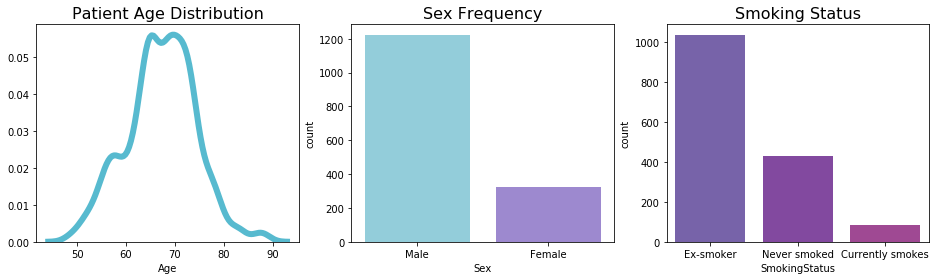

In [27]:
# Figure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 4))

f1 = sns.distplot(train["Age"], ax=ax1, color=custom_colors[1], hist=False, kde_kws=dict(lw=6, ls="-"))
f2 = sns.countplot(train["Sex"], ax=ax2, palette=custom_colors[2:4])
f3 = sns.countplot(train["SmokingStatus"], ax=ax3, palette = custom_colors[4:7])

f1.set_title("Patient Age Distribution", fontsize=16)
f2.set_title("Sex Frequency", fontsize=16)
f3.set_title("Smoking Status", fontsize=16);

In [ ]:
def load_scans(dcm_path):
    files = listdir(dcm_path)
    file_nums = [np.int(file.split(".")[0]) for file in files]
    sorted_file_nums = np.sort(file_nums)[::-1]
    slices = [pydicom.dcmread(dcm_path + "/" + str(file_num) + ".dcm" ) for file_num in sorted_file_nums]
    return slices

In [91]:
from glob import glob
import dicom
import os
import pydicom
import numpy as np
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF

In [40]:
data_path = "/Users/annie/Desktop/CSC 8850 Advan Machine Learning/osic-pulmonary-fibrosis-progression/train/"

In [41]:
# Each patient has a directory of scans
patients = os.listdir(data_path)
patients

['ID00296637202279895784347',
 'ID00032637202181710233084',
 'ID00061637202188184085559',
 'ID00232637202260377586117',
 'ID00322637202284842245491',
 'ID00329637202285906759848',
 'ID00027637202179689871102',
 'ID00011637202177653955184',
 'ID00042637202184406822975',
 'ID00086637202203494931510',
 'ID00023637202179104603099',
 'ID00235637202261451839085',
 'ID00168637202237852027833',
 'ID00078637202199415319443',
 'ID00331637202286306023714',
 'ID00312637202282607344793',
 'ID00283637202278714365037',
 'ID00365637202296085035729',
 'ID00414637202310318891556',
 'ID00267637202270790561585',
 'ID00400637202305055099402',
 'ID00076637202199015035026',
 'ID00173637202238329754031',
 'ID00192637202245493238298',
 'ID00364637202296074419422',
 'ID00180637202240177410333',
 'ID00132637202222178761324',
 'ID00048637202185016727717',
 'ID00407637202308788732304',
 'ID00426637202313170790466',
 'ID00167637202237397919352',
 'ID00136637202224951350618',
 'ID00305637202281772703145',
 '.DS_Stor

In [70]:
output_path = "../osic-pulmonary-fibrosis-progression/output_dicom/"
g = glob(data_path + patients[0] + '/*.dcm')
g

['/Users/annie/Desktop/CSC 8850 Advan Machine Learning/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347/16.dcm',
 '/Users/annie/Desktop/CSC 8850 Advan Machine Learning/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347/17.dcm',
 '/Users/annie/Desktop/CSC 8850 Advan Machine Learning/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347/15.dcm',
 '/Users/annie/Desktop/CSC 8850 Advan Machine Learning/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347/29.dcm',
 '/Users/annie/Desktop/CSC 8850 Advan Machine Learning/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347/28.dcm',
 '/Users/annie/Desktop/CSC 8850 Advan Machine Learning/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347/14.dcm',
 '/Users/annie/Desktop/CSC 8850 Advan Machine Learning/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347/10.dcm',
 '/Users/annie/Desktop/CSC 8850 Advan Machine Learning/osic-pulmonary-fibros

In [58]:
def load_scan(path):
    slices = [pydicom.read_file(s) for s in glob(data_path + patients[0] + '/*.dcm')]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [59]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [60]:
id_num = patients[0]
id_num

'ID00296637202279895784347'

In [63]:
id = 0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

In [71]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

In [83]:
failed_to_process = []
for id_num in patients:
    try:
        scan_path = data_path + id_num
        patient = load_scan(scan_path)
        imgs = get_pixels_hu(patient)
        if not os.path.exists(output_path + id_num + "/"):
            os.makedirs(output_path + id_num + "/")
        save_to = output_path + id_num + "/" + "fullimages_%d.npy" % (id)
        id +=1
        np.save(save_to, imgs)
    except Exception as e: 
        print(e)
        failed_to_process.append(id_num)

[Errno 20] Not a directory: '../osic-pulmonary-fibrosis-progression/output_dicom/.DS_Store/'


In [84]:
#.DS_Store can be ignored
failed_to_process

['.DS_Store']

In [78]:
example_img = "../osic-pulmonary-fibrosis-progression/output_dicom/ID00296637202279895784347/fullimages_0.npy"

In [79]:
file_used = example_img
imgs_to_process = np.load(file_used).astype(np.float64) 

In [80]:
imgs_to_process.shape

(31, 512, 512)

In [85]:
id = 0
imgs_to_process = np.load(output_path+'ID00296637202279895784347/fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

#sample_stack(imgs_to_process)

In [86]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    # made a change here, casting these two things to list. didn't check to see if it was
    # the right thing to do
    spacing = map(float, (list([scan[0].SliceThickness]) + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [87]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0
    
    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
    
    return mask*img

In [89]:
patients_to_process = os.listdir("../osic-pulmonary-fibrosis-progression/output_dicom/")
hu_images = "../osic-pulmonary-fibrosis-progression/output_dicom/"

In [92]:
for patient_id in patients_to_process:
    try:
        patient = load_scan(data_path + patient_id + "/")
        patient_path = hu_images + patient_id + "/"
    #     hu_img = os.listdir(patient_path)[0]
    #     filename = patient_path + hu_img
    #     imgs_to_process = np.load(filename)
        imgs_to_process = get_pixels_hu(patient)
        print("Shape before resampling\t", imgs_to_process.shape)
        imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
        print("Shape after resampling\t", imgs_after_resamp.shape)
        masked_lung = []
        for img in imgs_after_resamp:
            masked_lung.append(make_lungmask(img))
        masked_lung = np.array(masked_lung)
        output_dir = "../masked_imgs/" + patient_id + "/"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        np.save(output_dir + "masked_lung.npy", masked_lung)
    except Exception as e: 
        print(e)
        failed_to_process.append(id_num)

Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)


Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)
Shape after resampling	 (310, 366, 366)
Shape before resampling	 (31, 512, 512)


In [112]:
mask_path = '../masked_imgs'

patients = os.listdir(mask_path)
patients.remove(".DS_Store")

In [116]:
patients

['ID00296637202279895784347',
 'ID00032637202181710233084',
 'ID00061637202188184085559',
 'ID00232637202260377586117',
 'ID00322637202284842245491',
 'ID00329637202285906759848',
 'ID00027637202179689871102',
 'ID00011637202177653955184',
 'ID00042637202184406822975',
 'ID00086637202203494931510',
 'ID00023637202179104603099',
 'ID00235637202261451839085',
 'ID00168637202237852027833',
 'ID00078637202199415319443',
 'ID00331637202286306023714',
 'ID00312637202282607344793',
 'ID00283637202278714365037',
 'ID00365637202296085035729',
 'ID00414637202310318891556',
 'ID00267637202270790561585',
 'ID00400637202305055099402',
 'ID00076637202199015035026',
 'ID00173637202238329754031',
 'ID00192637202245493238298',
 'ID00364637202296074419422',
 'ID00180637202240177410333',
 'ID00132637202222178761324',
 'ID00048637202185016727717',
 'ID00407637202308788732304',
 'ID00426637202313170790466',
 'ID00167637202237397919352',
 'ID00136637202224951350618',
 'ID00305637202281772703145',
 'ID002916

In [118]:
imgs = []
for patient in patients:
    img_path = "../masked_imgs/" + patient + "/"
    imgs.append(np.load(img_path + 'masked_lung.npy'))

In [119]:
imgs = np.array(imgs)

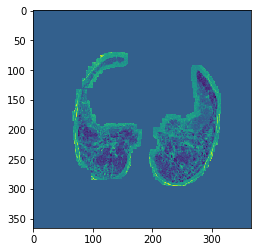

In [121]:
plt.imshow(imgs[0][200,:,:])

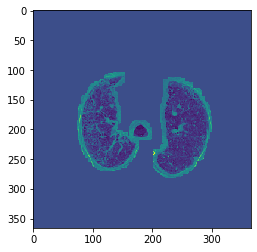

In [164]:
plt.imshow(imgs[0][100,:,:])

In [127]:
imgs[0].shape

(310, 366, 366)

In [122]:
from skimage.transform import resize

In [132]:
update_imgs=[]

In [134]:
for i in range(imgs.shape[0]):
    update_imgs.append(resize(imgs[i],(200, 200, 200),anti_aliasing=True))

In [136]:
update_imgs = np.array(update_imgs)

In [165]:
update_imgs.shape

(176, 200, 200, 200)

In [218]:
train = []
for j in range(update_imgs.shape[0]-1):
    for i in range(update_imgs[j].shape[2]):
        if (update_imgs[j][i,:,:] == np.zeros((200,200))).all():
            continue
        else:
            train.append(update_imgs[j][i,:,:].reshape(-1))
train = np.array(train)

In [219]:
test = []
for i in range(update_imgs[-1].shape[2]):
    if (update_imgs[-1][i,:,:] == np.zeros((200,200))).all():
        continue
    else:
        test.append(update_imgs[-1][i,:,:].reshape(-1))
test = np.array(test)

In [220]:
train.shape

(35000, 40000)

In [221]:
train_labels = np.random.randn(train.shape[0])

In [222]:
train_labels.shape

(35000,)

In [223]:
test.shape

(200, 40000)

In [224]:
train_labels

array([ 0.33525676,  0.33381944, -0.15027212, ..., -1.38399584,
       -0.20179435,  0.60745533])

In [225]:
test_labels = np.random.randn(test.shape[0])

In [226]:
test_labels.shape

(200,)

In [227]:
test_labels

array([-1.39578316, -0.15350443,  2.62935369, -0.68664075,  0.61926918,
        1.18540383,  1.55488394,  1.12267874, -2.07509042, -2.20125654,
        0.18628452,  1.45490615, -0.17384177,  0.78387586, -0.52188911,
        0.43547193, -0.31468887, -1.12886524,  0.36063031,  0.26566429,
       -0.04411909,  0.03336947,  1.492859  , -3.180634  , -0.16019868,
       -0.7109228 ,  0.54970758,  0.51836705,  1.0507499 , -0.90736015,
        0.20557204, -0.35163554, -0.60919559,  1.20701371, -0.55466219,
        1.39126375, -1.18904811, -2.22925536,  0.98411151,  0.59000908,
        1.33343034,  0.8821338 ,  2.22685429,  0.74807841, -0.79895074,
       -0.68929542,  0.88244573, -0.56246698,  0.3213965 ,  0.50729899,
       -0.46933205,  0.95372838, -0.81321063,  1.56450361,  1.44723127,
       -1.05132084, -0.19325777, -0.00768354, -1.56696986, -0.20096368,
        0.21789609,  0.32006366,  0.22976198,  1.17489757, -0.27702848,
        0.53451748, -1.1919376 , -0.87248838,  0.38082602, -1.21

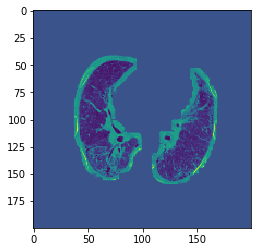

In [228]:
plt.imshow(train[100].reshape(200,200))

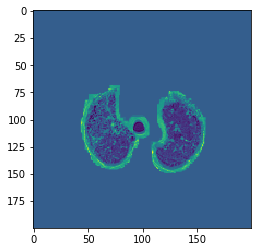

In [229]:
plt.imshow(test[50].reshape(200,200))

In [230]:
from sklearn.svm import SVR

In [231]:
clf = SVR()

In [ ]:
clf.fit(train, train_labels)

In [ ]:
#clf.predict(test)